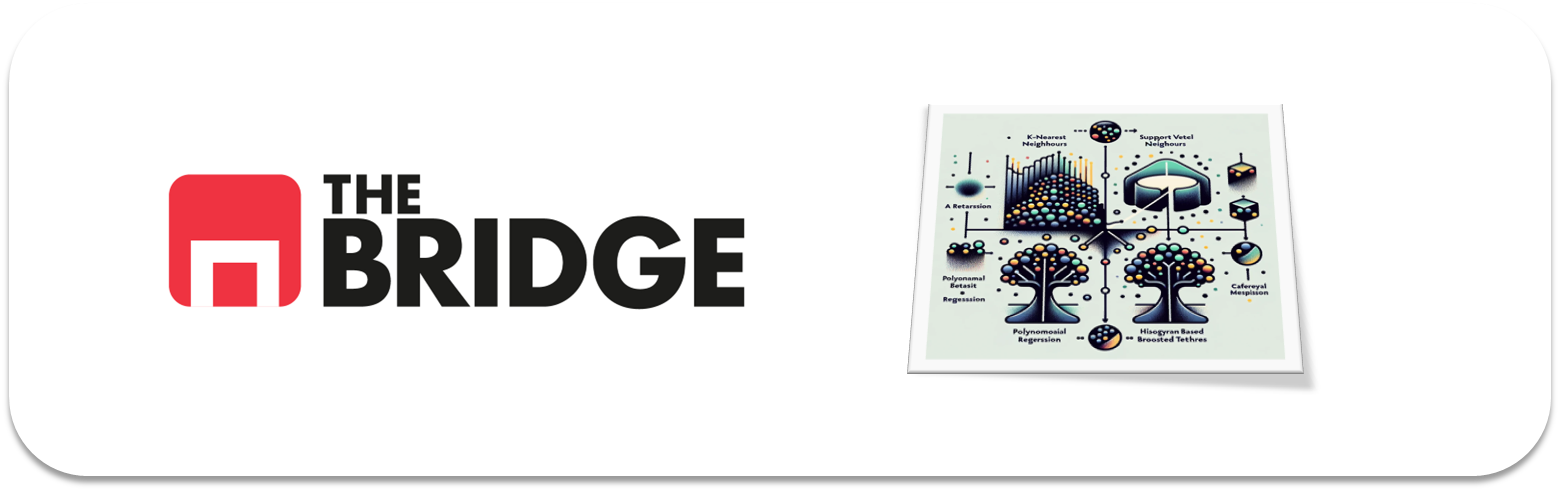

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
import toolbox_ML as tb

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [3]:
df = pd.read_csv("./data/credit_npo.csv", sep= ",")
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [23]:
df.dropna(subset=['NumberOfDependents'], inplace=True)
median_monthly_income = df['MonthlyIncome'].median()
df['MonthlyIncome'].fillna(median_monthly_income, inplace=True)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12360 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12360 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12360 non-null  float64
 2   age                                   12360 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12360 non-null  int64  
 4   DebtRatio                             12360 non-null  float64
 5   MonthlyIncome                         12360 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12360 non-null  int64  
 7   NumberOfTimes90DaysLate               12360 non-null  int64  
 8   NumberRealEstateLoansOrLines          12360 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12360 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), int64

In [4]:
tb.describir_df(df)

,Tipos,% Faltante,Valores Únicos,% Cardinalidad
SeriousDlqin2yrs,int64,0.00,2,0.02
RevolvingUtilizationOfUnsecuredLines,float64,0.00,10764,85.86
age,int64,0.00,78,0.62
NumberOfTime30-59DaysPastDueNotWorse,int64,0.00,10,0.08
DebtRatio,float64,0.00,11547,92.10
MonthlyIncome,float64,5.75,4167,33.24
NumberOfOpenCreditLinesAndLoans,int64,0.00,43,0.34
NumberOfTimes90DaysLate,int64,0.00,13,0.10
NumberRealEstateLoansOrLines,int64,0.00,16,0.13
NumberOfTime60-89DaysPastDueNotWorse,int64,0.00,8,0.06


In [9]:
tb.tipifica_variables(df, umbral_categoria= 7, umbral_continua= 9)

,nombre_variable,tipo_variable,cardinalidad,cardinalidad_porcentaje,tipo_sugerido
0,SeriousDlqin2yrs,int64,2,0.02,Binaria
1,RevolvingUtilizationOfUnsecuredLines,float64,10764,85.86,Numérica continua
2,age,int64,78,0.62,Numérica continua
3,NumberOfTime30-59DaysPastDueNotWorse,int64,10,0.08,Numérica continua
4,DebtRatio,float64,11547,92.10,Numérica continua
5,MonthlyIncome,float64,4167,33.24,Numérica continua
6,NumberOfOpenCreditLinesAndLoans,int64,43,0.34,Numérica continua
7,NumberOfTimes90DaysLate,int64,13,0.10,Numérica continua
8,NumberRealEstateLoansOrLines,int64,16,0.13,Numérica continua
9,NumberOfTime60-89DaysPastDueNotWorse,int64,8,0.06,Numérica discreta


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Estamos ante un problema de clasificacion creo yo, intentamos ver si se va a entrar en la categoria de "problemas en 2 años" o si no se va a dar el caso. Atendiendo a esto la variable target es "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

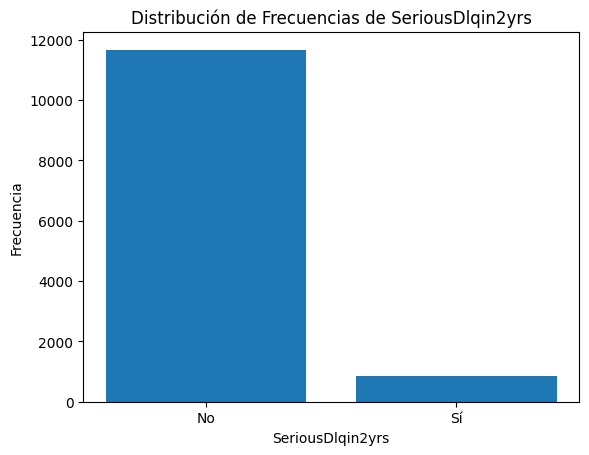

In [11]:

data_counts = df['SeriousDlqin2yrs'].value_counts()

plt.bar(data_counts.index, data_counts.values)
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencias de SeriousDlqin2yrs')
plt.xticks(data_counts.index, ['No', 'Sí'])
plt.show()



### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [25]:
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


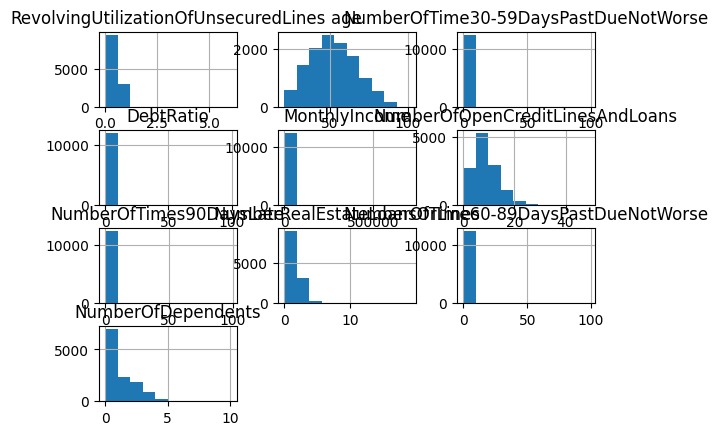

In [26]:
X.hist()
logs= ['RevolvingUtilizationOfUnsecuredLines','NumberOfTime30-59DaysPastDueNotWorse','DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines','NumberOfTime60-89DaysPastDueNotWorse']

array([[<Axes: title={'center': 'RevolvingUtilizationOfUnsecuredLines'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'NumberOfTime30-59DaysPastDueNotWorse'}>],
       [<Axes: title={'center': 'DebtRatio'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumberOfOpenCreditLinesAndLoans'}>],
       [<Axes: title={'center': 'NumberOfTimes90DaysLate'}>,
        <Axes: title={'center': 'NumberRealEstateLoansOrLines'}>,
        <Axes: title={'center': 'NumberOfTime60-89DaysPastDueNotWorse'}>],
       [<Axes: title={'center': 'NumberOfDependents'}>, <Axes: >,
        <Axes: >]], dtype=object)

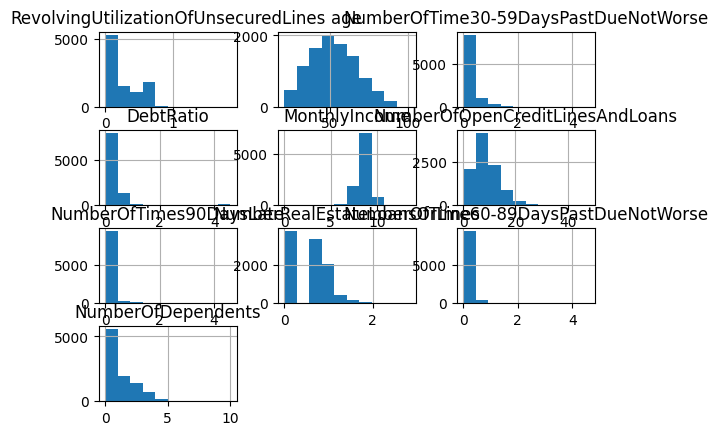

In [27]:
for columna in logs:
    X_train[columna] = np.log(X_train[columna] + 1)
    X_test[columna] = np.log(X_test[columna] + 1)


X_train.hist()

In [28]:
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
    print(f'{name}: Recall medio: {scores.mean()}, Desviación estándar: {scores.std()}')

KNN: Recall medio: 0.03564400221116639, Desviación estándar: 0.017272111243164346


c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression: Recall medio: 0.15575456053067993, Desviación estándar: 0.029852580661446425
Random Forest: Recall medio: 0.18687672747374237, Desviación estándar: 0.04432798009761415


In [29]:


scaler = StandardScaler()

# Seleccionar solo las columnas numéricas para escalar
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Escalar las columnas numéricas
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])


In [30]:
#Modelos con los valores escalados pero sin hiperparametros 
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
    print(f'{name}: Recall medio: {scores.mean()}, Desviación estándar: {scores.std()}')

KNN: Recall medio: 0.03564400221116639, Desviación estándar: 0.017272111243164346


c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression: Recall medio: 0.15575456053067993, Desviación estándar: 0.029852580661446425
Random Forest: Recall medio: 0.1868767274737424, Desviación estándar: 0.04177907468502885


In [32]:
clase_mayoritaria = X_train[y_train == 0]
clase_minoritaria = X_train[y_train == 1]

# Bajomuestrear la clase mayoritaria
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples=len(clase_minoritaria),  # igual al número de la clase minoritaria
                                          random_state=42)

#
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], 
                                  y_train.loc[clase_minoritaria.index]])
y_train_bajomuestreo.value_counts(True)


SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [33]:
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}
for name, model in models.items():
    scores = cross_val_score(model, X_train_bajomuestreo, y_train_bajomuestreo, cv=5, scoring='recall')
    print(f'{name}: Recall medio: {scores.mean()}, Desviación estándar: {scores.std()}')

KNN: Recall medio: 0.5342067440574904, Desviación estándar: 0.03386923758381249


c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Logistic Regression: Recall medio: 0.743305693753455, Desviación estándar: 0.027319173277079865
Random Forest: Recall medio: 0.7685903814262023, Desviación estándar: 0.029095168960706057


In [34]:
# Parámetros de búsqueda para cada modelo
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_logistic_regression = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

param_grid_random_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Diccionario de parámetros para cada modelo
param_grids = {
    'KNN': param_grid_knn,
    'Logistic Regression': param_grid_logistic_regression,
    'Random Forest': param_grid_random_forest
}

# Realizar la búsqueda de hiperparámetros para cada modelo
best_estimators = {}
for name, model in models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f'Mejores hiperparámetros para {name}: {grid_search.best_params_}')



Mejores hiperparámetros para KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kaled\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Mejores hiperparámetros para Logistic Regression: {'C': 10, 'penalty': 'l2'}
Mejores hiperparámetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [35]:
best_hyperparameters = {
    'KNN': {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'},
    'Logistic Regression': {'C': 10, 'penalty': 'l2', 'max_iter': 1000},
    'Random Forest': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
}

# Actualizar los modelos con los mejores hiperparámetros
models = {
    'KNN': KNeighborsClassifier(**best_hyperparameters['KNN']),
    'Logistic Regression': LogisticRegression(**best_hyperparameters['Logistic Regression']),
    'Random Forest': RandomForestClassifier(**best_hyperparameters['Random Forest'])
}

# Validación cruzada sin optimización de hiperparámetros
for name, model in models.items():
    scores = cross_val_score(model, X_train_bajomuestreo, y_train_bajomuestreo, cv=5, scoring='recall')
    print(f'{name}: Recall medio: {scores.mean()}, Desviación estándar: {scores.std()}')


KNN: Recall medio: 0.5326920950801547, Desviación estándar: 0.02518987304286735
Logistic Regression: Recall medio: 0.7477833056937535, Desviación estándar: 0.02083470284554564
Random Forest: Recall medio: 0.7700718629076838, Desviación estándar: 0.03150030619670754


No se muy bien como hacer un analisis de errores asi que.. 